In [52]:
import numpy as np
import pandas
import pylab as plt  # matplotlib的一个子包
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error # 平方绝对误差
from sklearn.metrics import r2_score  # R square

import sys 
sys.path.append(r'D:\\xueqing\\workplace\\lstm\\Time-Series-Prediction-with-LSTM')  # 要用绝对路径
from utils import eemd_tools, data_tools, networks_factory, data_metrics
from utils.constants import const

In [53]:
# fix random seed for reproducibility
np.random.seed(7)

# 导入数据

In [54]:
data_multi = np.load(const.PROJECT_DIR + "/data/wavelets/apple_multi.npy")
print("# shape", data_multi.shape)  # not .shape()

# shape (1901, 4)


## data preprocessing

In [55]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(data_multi)

output = 1
lags = [13]  # test one

multi_data_supervised = list()
for i, lag in enumerate(lags):
    reframed = data_tools.series_to_supervised(scaled, lag, output)
    # drop columns we don't want to predict
    index_drop = [-j-1 for j in range(data_multi.shape[1] - 1)]
    reframed.drop(reframed.columns[index_drop], axis=1, inplace=True)
    data_supervised = reframed.values
    multi_data_supervised.append(data_supervised)
    print("# shape:", reframed.shape)
    print(len(data_multi) == len(reframed) + lag)
    # print(reframed.head(3))

print("-----------done--------------")
print(len(multi_data_supervised))

# shape: (1888, 53)
True
-----------done--------------
1


# LSTM  
validation_split=const.VALIDATION_SCALE

In [56]:
n_lstm_neurons = 32
n_epoch = networks_factory.EPOCHS
n_batch_size = networks_factory.BATCH_SIZE

In [57]:
df_metrics = pandas.DataFrame(index=['RMSE', 'MAPE', 'Dstat'], columns=np.arange(0, len(multi_data_supervised)))
for i, data_supervised in enumerate(multi_data_supervised):
    # split into train and test sets
    train_size = int(len(data_supervised) * 0.80)
    test_size = len(data_supervised) - train_size
    train_data, test_data = data_supervised[0:train_size,:], data_supervised[train_size:len(data_multi),:]
   
    # split into input and outputs
    train_X, train_Y = train_data[:, :-1], train_data[:, -1]
    test_X, test_Y = test_data[:, :-1], test_data[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    time_steps = lags[i]  # There are dependencies
    print("-----------time steps: %d--------------" % time_steps)
    train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]//time_steps))
    test_X = test_X.reshape((test_X.shape[0], time_steps, test_X.shape[1]//time_steps))
    
    # create and fit the LSTM network
    n_dims = train_X.shape[2]
    s, model = networks_factory.create_lstm_model(lstm_neurons=n_lstm_neurons, hidden_layers=2, 
                                                  lenth=time_steps, dims=n_dims, n_out=1)
    
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_Y, epochs=n_epoch, batch_size=n_batch_size, validation_split=const.VALIDATION_SCALE, 
                        verbose=0, callbacks=[networks_factory.ES])
    print("# Finished Training...")
    
    # make a prediction
    train_predict = model.predict(train_X)
    test_predict = model.predict(test_X)
    # invert predictions
    inv_trainP, inv_trainY = data_tools.inv_transform_multi(scaler, train_X, train_predict, train_Y)
    inv_testP, inv_testY = data_tools.inv_transform_multi(scaler, test_X, test_predict, test_Y)

    # calculate RMSE, MAPE, Dstat
    train_rmse = sqrt(mean_squared_error(inv_trainP, inv_trainY))
    test_rmse = sqrt(mean_squared_error(inv_testP, inv_testY))
    print('Train RMSE: %.4f, Test RMSE: %.4f' % (train_rmse, test_rmse))
    train_mape = data_metrics.MAPE(inv_trainP, inv_trainY)
    test_mape = data_metrics.MAPE(inv_testP, inv_testY)
    print('Train MAPE: %.4f, Test MAPE: %.4f' % (train_mape, test_mape))
    train_ds = data_metrics.Dstat(inv_trainP, inv_trainY)
    test_ds = data_metrics.Dstat(inv_testP, inv_testY)
    print('Train Dstat: %.4f, Test Dstat: %.4f' % (train_ds, test_ds))

    # write to dataframe
    df_metrics.iloc[0, i] = test_rmse
    df_metrics.iloc[1, i] = test_mape
    df_metrics.iloc[2, i] = test_ds

print("# All Done!")

-----------time steps: 13--------------
Epoch 00484: early stopping
# Finished Training...
Train RMSE: 0.1235, Test RMSE: 0.0586
Train MAPE: 0.0077, Test MAPE: 0.0058
Train Dstat: 0.8310, Test Dstat: 0.8488
# All Done!


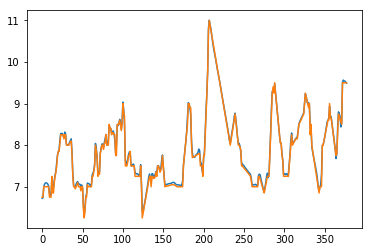

In [58]:
plt.plot(inv_testP)
plt.plot(inv_testY)
plt.show()